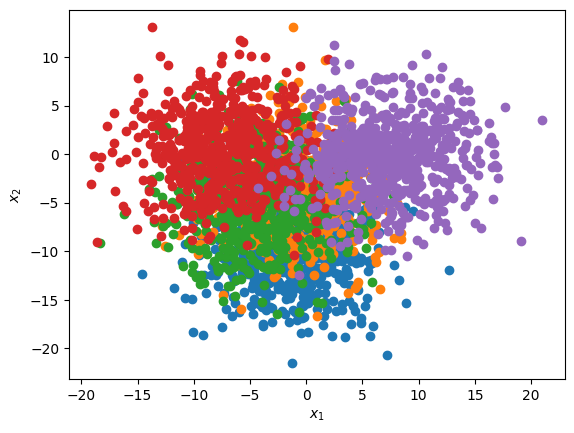

47/47 [==============================] - 0s 2ms/step - loss: 0.5917 - accuracy: 0.7807


Test Accuracy: 0.781
47/47 [==============================] - 0s 2ms/step - loss: 0.5803 - accuracy: 0.7767


Test Accuracy: 0.777
47/47 [==============================] - 0s 2ms/step - loss: 0.5773 - accuracy: 0.7747


Test Accuracy: 0.775
47/47 [==============================] - 0s 3ms/step - loss: 0.5768 - accuracy: 0.7740
Test Accuracy: 0.774


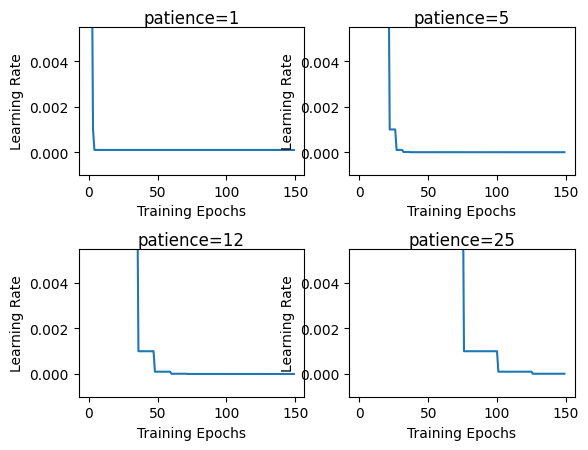

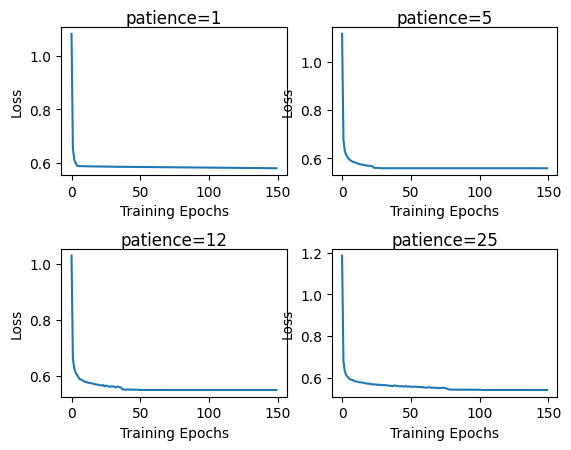

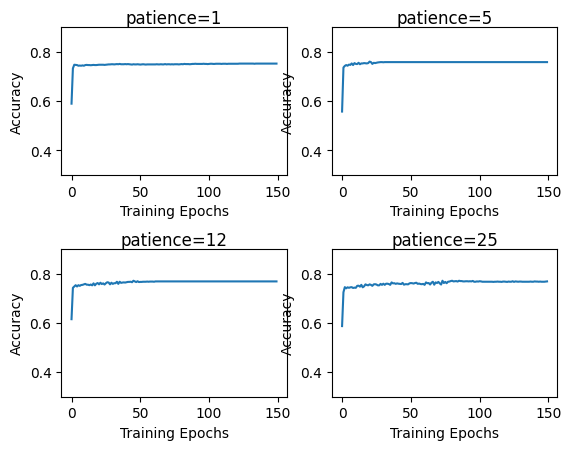

In [3]:
from sklearn.datasets import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras import initializers
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
from keras import backend
from matplotlib import pyplot as plt
from numpy import where

class LearningRateMonitor(Callback):
    # start of training
    def on_train_begin(self, logs={}):
        self.lrate = list()
 
    # end of each training epoch
    def on_epoch_end(self, epoch, logs={}):
        # get and store the learning rate
        optimizer = self.model.optimizer
        lrate = float(backend.get_value(self.model.optimizer.lr))
        self.lrate.append(lrate)

Nclass = 5
X, y = make_blobs(n_samples=3000, centers=Nclass,
                  n_features=4, cluster_std=4.0, random_state=2)
plt.figure(1)

for class_value in range(Nclass):
    row_ix = where(y == class_value)
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
    
plt.xlabel(r"$x_1$"), plt.ylabel(r"$x_2$")
plt.show()

def prepare_data():
    # generate 4d dataset for classification
    X, y = make_blobs(n_samples=3000, centers=Nclass,
                      n_features=4, cluster_std=4, random_state=2)
    
    y = to_categorical(y)
    # Using first n_train sample for training dataset
    n_train = 1500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    # Using the rest for testing dataset
    trainy, testy = y[:n_train], y[n_train:]
    return trainX, trainy, testX, testy

def fit_model(trainX, trainy, testX, testy, patience):
    # Defining simple MLP model that expects two input variables
    model = Sequential()
    initializer = initializers.GlorotUniform(seed=1)
    # A single hidden layer with 50 nodes
    model.add(Dense(50, input_dim=4, activation='relu', kernel_initializer= initializer))
    
    # An output layer with 5 nodes to predict probability for each of 5 classes
    model.add(Dense(5, activation='softmax'))
    # compile the MLP network  ----------------------------------------------------------------------
    # The loss function : ‘sparse_categorical_crossentropy‘-appropriate for integer encoded class labels
    opt = SGD(lr=0.005, momentum=0.05)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    # fit the MLP network ---------------------------------------------------------------------------
    # Model will be fitted for 150 training epochs
    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, min_delta=1E-7)
    lrm = LearningRateMonitor()
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=150, verbose=0, callbacks=[rlrp, lrm])
    # evaluate the model performance-----------------------------------------------------------------
    loss, acc = model.evaluate(testX, testy, verbose=1)
    print('Test Accuracy: %.3f' % acc)
    
    return lrm.lrate, history.history['loss'], history.history['accuracy']
    

# create line plots for a series ---------------------------------------------
def line_plots(patiences, series, index):
    for i in range(len(patiences)):
        # assign different plot number
        plt.subplot(220 + (i+1))
        plt.plot(series[i])
        plt.title('patience='+str(patiences[i]), pad=-80)
        if (index==1):
            plt.ylim([-0.001, 0.0055]), plt.xlabel('Training Epochs'), plt.ylabel('Learning Rate')
        elif (index==2):
            plt.xlabel('Training Epochs'), plt.ylabel('Loss')
        elif (index==3):
            plt.ylim([0.3, 0.9]), plt.xlabel('Training Epochs'), plt.ylabel('Accuracy')
    plt.show()
# prepare training and testing datasets --------------------------------------
trainX, trainy, testX, testy = prepare_data()
# create learning curves for different patiences
patiences = [1, 5, 12, 25]
lr_list, loss_list, acc_list, = list(), list(), list()
for i in range(len(patiences)):
    # Training MLP model and plot learning curves for a patience
    lr, loss, acc = fit_model(trainX, trainy, testX, testy, patiences[i])
    lr_list.append(lr)
    loss_list.append(loss)
    acc_list.append(acc)
    
# plot learning rates curve
plt.subplots_adjust(hspace=0.5)
line_plots(patiences, lr_list, 1)

# plot loss curve
plt.subplots_adjust(hspace=0.5)
line_plots(patiences, loss_list, 2)
# plot accuracy curve
plt.subplots_adjust(hspace=0.5)
line_plots(patiences, acc_list, 3)
plt.show()